In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import pandas as pd
np.random.seed(6)
import math
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import time
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score

# 【問題1】SVM分類器のクラスを作成する

In [4]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [5]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=23)

In [11]:
class ScratchSVMClassifier():
    """
    SVM回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter

    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        self.X = X
        self.y = y[:, np.newaxis]
        self.X_val = X_val
        self.y_val = y_val
        self.lamda = np.random.randn(self.X.shape[0],1)
        self._gradient_descent()
        theta = 1e-5
        sv_index =  np.where(self.lamda> theta)[0] #サポートベクトルのチョイス
        self.X_sv = self.X[sv_index].copy() # XのSVMの特徴量を抽出
        self.y_sv_label = y[sv_index].copy() #YラベルのSVMのラベルを抽出
        self.lamda_sv = self.lamda[sv_index].copy() #サポートベクトルを抽出
            
    
    
    def _linear_hypothesis(self,X1,X2):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
          次の形のndarray, shape (n_samples, n_samples)
          線形の仮定関数による推定結果

        """
        
        h = np.dot(X1,X2.T)
        return h



    def _gradient_descent(self):
        """
        最適化した勾配を返す。
       
        Returns
        -------
            勾配を最適化した結果
        """
        sum_y =0
        alpha = 0.01
        t0 = time.time() #時間の計測
        for _ in range(self.iter):
            for i in range(len(self.y)):
                for j in range(len(self.y)):
                    sum_y +=self.lamda[j] * (self.y[i]*self.y[j]*self._linear_hypothesis(self.X[i,:],self.X[j,:]))
                self.lamda[i] = self.lamda[i] + alpha * (1 - sum_y)
                #サポートベクターの決定
                if self.lamda[i] < 0:
                    self.lamda[i] = 0
                sum_y = 0
        t1 = time.time()
        print('time : {}s'.format(t1-t0))
        return self.lamda
           
    
    #推定
    def predict(self,X_val):
        """
        SVM回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプルl

        Returnsz
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        predict_y = np.zeros((len(self.X_sv),))

        predict_y =np.sum(self.lamda_sv * self.y_sv_label[:, np.newaxis] * self._linear_hypothesis(X_val,self.X_sv).T ,axis=0)
        y = [-1 if i < 0 else 1 for i in predict_y] #予測結果の振り分け
        y = np.array(y)
        return y 
    
    def decision_region(self, X_train, y_train, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['target1', 'target2']):
        """
        2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
        背景の色が学習したモデルによる推定値から描画される。
        散布図の点は学習用データである。

        Parameters
        ----------------
        X_train : ndarray, shape(n_samples, 2)
            学習用データの特徴量
        y_train : ndarray, shape(n_samples,)
            学習用データの正解値
        step : float, (default : 0.1)
            推定値を計算する間隔を設定する
        title : str
            グラフのタイトルの文章を与える
        xlabel, ylabel : str
            軸ラベルの文章を与える
        target_names= : list of str
            凡例の一覧を与える
        """
        # setting
        scatter_color = ['red', 'blue']
        contourf_color = ['pink', 'skyblue']
        n_class = 2

        # pred
        mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
        mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
        pred = self.predict(mesh).reshape(mesh_f0.shape)
        
        # plot
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
        plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
        for i, target in enumerate(set(y_train)):
            plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
        patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
        
        
        plt.legend(handles=patches)
        plt.legend()
        
        #サポートベクターをプロットする
        plt.scatter(self.X_sv[:, 0], self.X_sv[:, 1], color='y')

        plt.show()


In [12]:
sv = ScratchSVMClassifier(100)

In [13]:
sv.fit(X_train,y_train)

time : 116.51866030693054s


In [14]:
y_label = sv.predict(X_test)

# 【問題3】指標値の算出

In [15]:
accuracy_score(y_test,y_label)

1.0

# 【問題4】決定領域の可視化

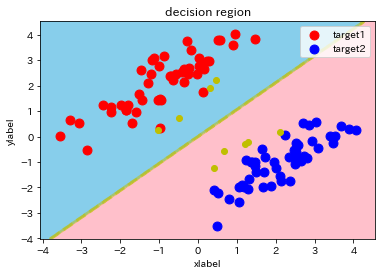

In [16]:
sv.decision_region(X_test,y_test)

# 【問題5】時間の計測

time : 116.51866030693054s

# 【問題6】ロジスティック回帰とSVM

[代表的な機械学習手法一覧](https://qiita.com/tomomoto/items/b3fd1ec7f9b68ab6dfe2)

In [ ]:
ロジスティック回帰
概要： 回帰によって分類する手法。線形回帰の出力をロジット関数に入力することで、2分類問題に対応した回帰モデル。
予測対象: 分類
可読性： ○
並列処理： ×
過学習防止策： ステップワイズ(AIC基準)による変数削減, L1/２正則化など 

サポートベクターマシーン(SVM)
概要： 回帰によって分類する手法。マージン最大化を取り入れることで、少ないデータでも汎化性能が高い2分類回帰モデルを実現。ただし、学習時間は長くなる。
予測対象: 分類
可読性： ○
並列処理： ×
過学習防止策： モデルに組み込まれている（マージン最大化）など

[海外の参考文献](https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f)

ロジスティック回帰とは
ロジスティック回帰では、線形関数の出力を取得し、シグモイド関数（ロジスティック関数）を使用して[0,1]の範囲内の値を縮小する。 シグモイド関数はS字型の曲線で、任意の実数値を取り、それを0から1の範囲内の値にマッピングできますが、その範囲内では絶対に使用できません。 通常、押しつぶされた値がしきい値よりも大きい場合はラベル1を割り当て、そうでない場合はラベル0を割り当てます。これは「ロジスティック回帰」という名前を正当化します。 
ロジスティック回帰と線形回帰の違いは、ロジスティック回帰では離散的な結果が得られるのに対し、線形回帰では連続的な結果が得られること

主な違い

SVMは最も近いサポートベクトル間のマージンを最大化しようとするが、LRは事後クラス確率。 このように、SVMは2つのカテゴリに対して可能な限り運賃が低い解決策を見つけますが、LRはこの特性を持たない。